In [1]:
import warnings
warnings.filterwarnings('ignore')

<h1 style = "fontsize:400%;text-align:center;">QBUS3850: Time Series and Forecasting</h1>
<h2 style = "fontsize:300%;text-align:center;">Introduction</h2>
<h3 style = "fontsize:200%;text-align:center;">Lecture Notes</h3>


# Time Series and Forecasting 

- The focus of this course is **forecasting** (what a suprise).
- In this course we mostly consider numerical variables 
  - Example: electricity demand
- We will mostly use the history of that variable or **time series** itself.
  - Make a forecast $\hat{y}_{T+h}$ targeting $y_{T+h}$
  - Use $y_1,y_2,\dots,y_T$
-  Here $h$ is the forecast horizon.

# Forecasting v Prediction

- In other courses you have made predictions $\hat{y}=f(\mathbf{x})$, where $\mathbf{x}$ are some independent variables.
- A forecast is just a prediction in the future
- Any method can be used if $f(\mathbf{x})$ includes information available when the forecast is made
- Unlike general regression methods, in time series forecasting there are techniques to exploit the temporal structure or patterns in the data.

# What can we easily forecast?

In general it is easier to forecast a variable when:

1. We understand the factors that contribute to it;
2. When more data is available;
3. When the future is similar to the past;
4. When the forecasts do not affect the quantity we are trying to forecast.


# Your turn

- In small groups have a think about:
  - Variables that we need to forecast,
  - How forecasting these variables can improve business decisions,
  - Whether it is easy to forecast these variable.
- Discuss in groups for 10 minutes and then we will discuss together.

# Electricity Demand

- Forecasts at different **horizons** play an important role in the operation of electricity markets.
- Long term forecasts (10 to 30 years horizon) 
  - Used by by policy makers or investors to decide how to invest in infrastructure.
- Short term forecasts (up to 24-hour horizon) 
  - Used for operations, e.g. scheduling which generators produce electricity.
- Consider the short term forecasting problem to revise exponential smoothing models covered last semester.
 

# Electricity Data

In [2]:
import pandas as pd
from datetime import datetime
elec = pd.read_csv('electricity.csv', header=0, index_col=False, parse_dates=False, squeeze=True)
elec['SETTLEMENTDATE'] = pd.to_datetime(elec['SETTLEMENTDATE'])
elec = elec[['SETTLEMENTDATE','TOTALDEMAND']]
print(elec.head())

       SETTLEMENTDATE  TOTALDEMAND
0 2021-04-01 00:30:00      7012.00
1 2021-04-01 01:00:00      6815.37
2 2021-04-01 01:30:00      6495.25
3 2021-04-01 02:00:00      6308.43
4 2021-04-01 02:30:00      6179.93


# Line plot (1 month)

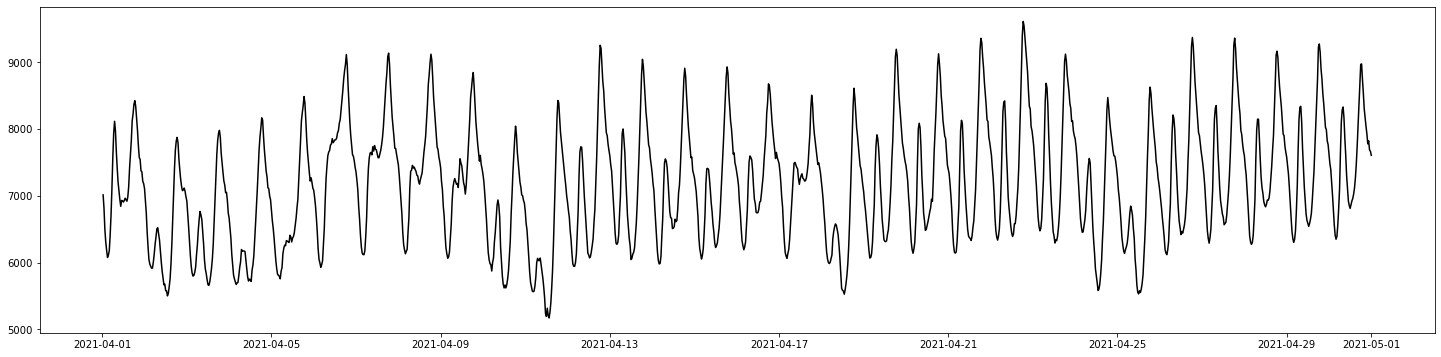

In [3]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(25, 6))
ax.plot(elec.SETTLEMENTDATE, elec.TOTALDEMAND, color='black')

# Line plot (1 day)

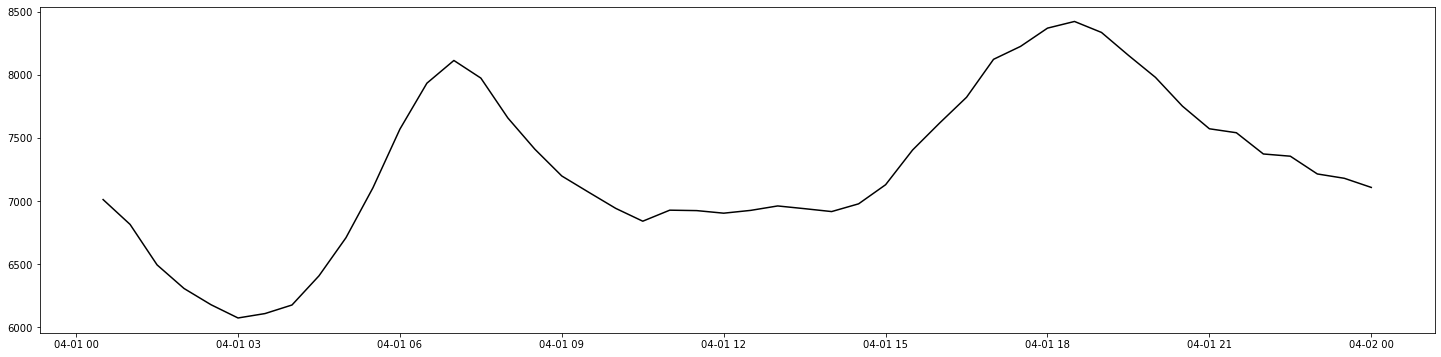

In [4]:
elec_ow = elec.head(n=2*24)
fig, ax = plt.subplots(figsize=(25, 6))
ax.plot(elec_ow.SETTLEMENTDATE, elec_ow.TOTALDEMAND, color='black')

# Patterns

- Electricity demand is lower: 
  - Overnight/ middle of day,
  - On weekends and public holidays,
  - In months with moderate temperature (not shown in plots above)
- All this can be deduced just by looking at the series itself!


# Simple Exponential Smoothing

- Simple (no trend, no seasonality)

$$\begin{align}\hat{y}_{t+h}&=l_t\\l_t&=\alpha y_t+(1-\alpha)l_{t-1}\end{align}$$

- Where $0\leq\alpha\leq 1$ and $l_0$ need to be estimated.
- The logic: Forecast is an average level of the time series where more recent are given greater weight in the forecast.


### Data Cleaning

The following code creates a test sample of the final day (48 half hours) and the remaining data is used for training.

In [5]:
import numpy as np
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
elec_clean = elec.set_index('SETTLEMENTDATE')
train = elec_clean.iloc[0:-48, :]
test = elec_clean.iloc[-48:, :]


### Fit model (Simple ES)

The following code fits the model

In [6]:
model = SimpleExpSmoothing(np.asarray(train['TOTALDEMAND']))
fit = model.fit()
fit.summary()


/home/anastasios/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Dep. Variable:,endog,No. Observations:,1392
Model:,SimpleExpSmoothing,SSE,57739558.709
Optimized:,True,AIC,14805.075
Trend:,None,BIC,14815.552
Seasonal:,None,AICC,14805.104
Seasonal Periods:,None,Date:,"Wed, 09 Feb 2022"
Box-Cox:,False,Time:,13:53:18
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9950000,alpha,True
initial_level,7012.0000,l.0,True


### Plot (Simple ES)

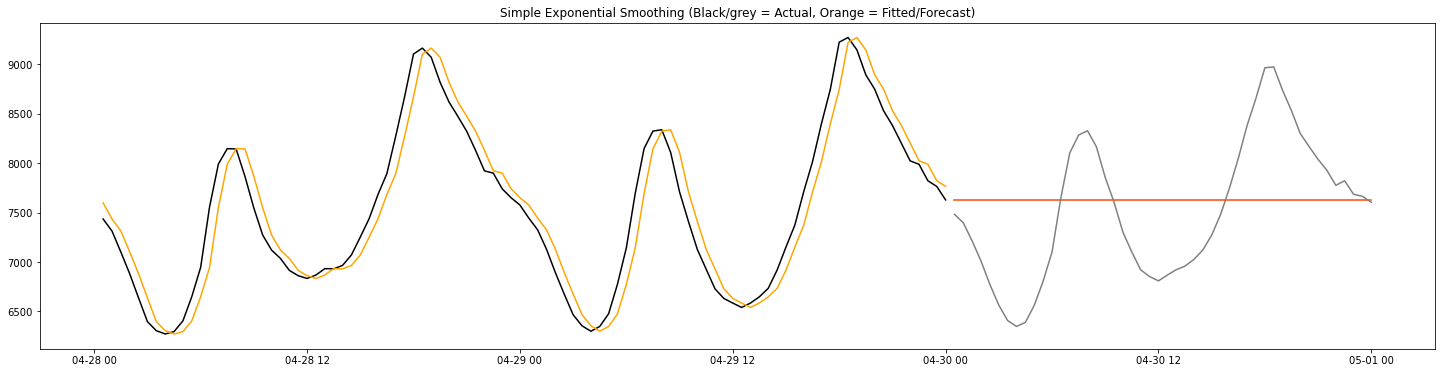

In [7]:
pred = test.copy()
pred = fit.forecast(48)
fitted = fit.fittedvalues
fig, ax = plt.subplots(figsize=(25, 6))
ax.plot(train.index[-96:], train.values[-96:],color='black')
ax.plot(train.index[-96:], fitted[-96:], color='orange')
ax.plot(test.index, pred,color='orangered')
ax.plot(test.index, test.values, color='grey')
plt.title("Simple Exponential Smoothing (Black/grey = Actual, Orange = Fitted/Forecast)");

# Holt exponential smoothing

- Corrects for trend

$$\begin{align}\hat{y}_{t+h}&=l_t+hb_t\\l_{t}&=\alpha y_t+(1-\alpha)(l_{t-1}+b_{t-1})\\b_t&=\beta(l_t-l_{t-1})+(1-\beta)b_{t-1}\end{align}$$

- where $0\leq\alpha\leq 1$, $0\leq\beta\leq 1$ and $l_0$ and $b_0$ need to be estimated.
- The logic: There is a trend also varying smoothly over time. Instead of flat forecasts, forecasts should be linear.

### Fit model (Holt)

The following code fits the model

In [8]:
model = Holt(np.asarray(train['TOTALDEMAND']))
fit = model.fit()
fit.summary()


Dep. Variable:,endog,No. Observations:,1392
Model:,Holt,SSE,17201041.078
Optimized:,True,AIC,13123.401
Trend:,Additive,BIC,13144.355
Seasonal:,None,AICC,13123.462
Seasonal Periods:,None,Date:,"Wed, 09 Feb 2022"
Box-Cox:,False,Time:,13:53:18
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9950000,alpha,True
smoothing_trend,0.9950000,beta,True


### Plot (Holt)

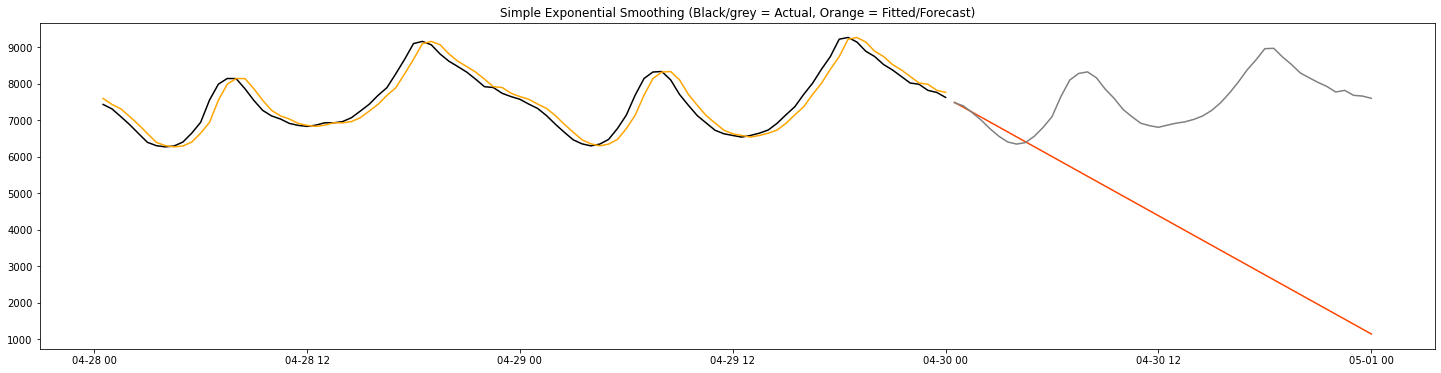

In [9]:
pred = fit.forecast(48)
fig, ax = plt.subplots(figsize=(25, 6))
ax.plot(train.index[-96:], train.values[-96:],color='black')
ax.plot(train.index[-96:], fitted[-96:], color='orange')
ax.plot(test.index, pred,color='orangered')
ax.plot(test.index, test.values, color='grey')
plt.title("Simple Exponential Smoothing (Black/grey = Actual, Orange = Fitted/Forecast)");

# Holt-Winters exponential smoothing

- Corrects for trend and seasonality. Additive form is:

$$\begin{align}\hat{y}_{t+h}&=l_t+hb_t+s_{t+h-m(k+1)}\\l_{t}&=\alpha y_t+(1-\alpha)(l_{t-1}+b_{t-1})\\b_t&=\beta(l_t-l_{t-1})+(1-\beta)b_{t-1}\\s_t&=\gamma(y_t-l_{t-1}-b_{t-1})+(1-\gamma)s_{t-m}\end{align}$$

- where $0\leq\alpha\leq 1$, $0\leq\beta\leq 1$, $0\leq\gamma\leq 1$ and $l_0$ and $b_0$ and $s_0,s_{-1},s_{-2},...$ need to be estimated.
- Note $m$ is the seasonal period and $k$ is the integer part of $(h-1)/m$.


# Seasonal period

- Think of *seasonal period* as the number of observations required for a pattern to repeat itself
- For example monthly data has a seasonal period of 12, for a pattern repeating every year
- In our example the period repeats every day. 
- With half hourly data that implies a seasonal period of 48.
- An argument could be made for a seasonal period of $48\times 7=336$ or $48\times 365=17520$.

### Fit model (Holt-Winters)

The following code fits the model

In [10]:
model = ExponentialSmoothing(np.asarray(train['TOTALDEMAND']),trend='add',seasonal='add',seasonal_periods=48)
fit = model.fit()
fit.summary()


Dep. Variable:,endog,No. Observations:,1392
Model:,ExponentialSmoothing,SSE,9027235.473
Optimized:,True,AIC,12321.946
Trend:,Additive,BIC,12594.348
Seasonal:,Additive,AICC,12326.389
Seasonal Periods:,48,Date:,"Wed, 09 Feb 2022"
Box-Cox:,False,Time:,13:53:19
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9268520,alpha,True
smoothing_trend,0.8947534,beta,True


### Plot (Holt-Winters)

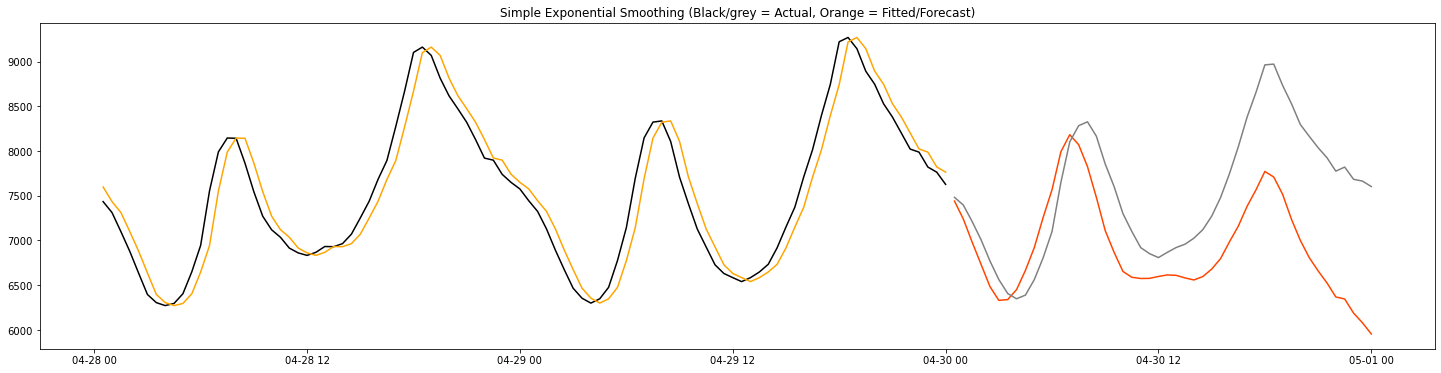

In [11]:
pred = fit.forecast(48)
fig, ax = plt.subplots(figsize=(25, 6))
ax.plot(train.index[-96:], train.values[-96:],color='black')
ax.plot(train.index[-96:], fitted[-96:], color='orange')
ax.plot(test.index, pred,color='orangered')
ax.plot(test.index, test.values, color='grey')
plt.title("Simple Exponential Smoothing (Black/grey = Actual, Orange = Fitted/Forecast)");

# Evaluating Forecasts

- In the previous example we had test and training data.
- We fit the model once and made 1-step ahead to 48 step ahead forecasts.
- We could evaluate the accuracy of these forecasts using mean square error, mean absolute error or other metrics.
- Is this the end of the story?

# Your turn

- Consider a case where only 1-step ahead forecasting is needed.
- Would the above evaluation be the best strategy?
- If not, what would be a better strategy (*Hint: think of leave one out validation*)?
- Discuss for 5 minutes (and don't cheat by looking at the next slide).

# Rolling or Window

- A common way to evaluate forecasts is via a rolling window.
  1. Fit the model from $y_1,...,y_{T_{\textrm{train}}}$ and make forecast $y_{T_{\textrm{train}}+1}$ 
  2. Fit the model from $y_2,...,y_{T_{\textrm{train}}+1}$ and make forecast $y_{T_{\textrm{train}}+2}$
  3. Fit the model from $y_3,...,y_{T_{\textrm{train}}+2}$ and make forecast $y_{T_{\textrm{train}}+3}$
  4. and so on...
- This gives a series of one-step ahead forecasts to evaluate one-step ahead forecast accuracy.

# Expanding Window

- A alternative way to evaluate forecasts is via a expanding window.
  1. Fit the model from $y_1,...,y_{T_{\textrm{train}}}$ and make forecast $\hat{y}_{T_{\textrm{train}}+1}$ 
  2. Fit the model from $y_{\color{red}{1}},...,y_{T_{\textrm{train}}+1}$ and make forecast $y_{T_{\textrm{train}}+2}$
  3. Fit the model from $y_{\color{red}{1}},...,y_{T_{\textrm{train}}+2}$ and make forecast $\hat{y}_{T_{\textrm{train}}+3}$
  4. and so on...
- Which do you think is better and why?

# Rolling v Expanding

- Expanding window mimics the process of using all available data whenever forecasts are made.
  - This is common in practice.
- Rolling windows use the same amount of training data
  - Rolling windows make sense if model parameters are unstable over time.
- Although the expanding/rolling windows described here use one-step ahead forecasts, we can also use multistep ahead forecasts too.
- Common Sense: *Evaluate forecasts in the way you anticipate you will be using forecasts!*

# Think probabilistically

- We often think of forecasts as single number or *point forecasts*, for example 
  - Electricity demand at 3PM tomorrow will be 8000 MWh
- Sometimes decisions may depend of the variance of a forecast, i.e.

$$Var(y_{T+h}|\mathcal{F}_{T})$$

- Other decisions may depend on quantiles, i.e.

$$q:\textrm{Pr}(y_{T+h}<q|\mathcal{F}_{T})=\alpha$$

# Example 1 : Newsvendor problem

- Retailer purchases goods for $c$ dollars, sells them for $p$ dollars, demand is $D$, quanity ordered is $q$
- Profit is $\pi=p min(q,D)-cq$
- If $D$ is normal with mean $\mu$ and variance $\sigma^2$ the optimal order quantity

$$q_{opt}=\mu+\sigma\Phi^{-1}\left(\frac{p-c}{p}\right)$$

- The optimal decision requires the forecast variance!

# Example 2 : Value at Risk

- Since the Basel II accords are a set of international recommendations for the regulation of banks.
- Under this accord, the value at risk (a forecast quantile) is the preferred measure of market risk.
- This is used to determine reserves of capital that should be held.
- Although this requirement has been superseeded by Basel III, value at risk is still common in practice.

# Example 3 : Everyday Examples


- Bank of England Fan charts  ([source](https://www.bankofengland.co.uk/-/media/boe/files/monetary-policy-report/2021/november/monetary-policy-report-november-2021.pdf?la=en&hash=72336FA2809F28D79CA9C1274ED3851261C61CA9))

<img src="BoE_fanchart.png" alt="drawing" width="600"/>



- Rain probability in weather apps.

<img src="weatherf.png" alt="weather" width="600"/>



# Confidence v Prediction Interval

- A *confidence interval* describes the uncertainty around my forecast due to parameter uncertainty
  - e.g. in a regression model uncertainty due to $\beta$
- A *prediction interval* also accounts for the uncertainty since the future outcome is unknown
  - e.g. in a regression model it will reflect the uncetainty in $\epsilon$
- Prediction intervals are wider than confidence intervals

# Probabilistic Forecasts

- A probabilistic forecast is a density (or probability mass function)

$$f(y_{T+h}|\mathcal{F}_T)$$

- From this we can get forecast variances, quantiles, prediction intervals
- We can also get point forecasts either as
  - The expected value $E(y_{T+h}|\mathcal{F}_T)$
  - The median $q:(y_{T+h}<q|\mathcal{F}_T)=0.5$